Dataset shape: (141, 9)

First 5 rows:
   temperature  humidity  wind_speed  rainfall  visibility  road_condition  \
0         28.5      65.2        12.3       0.0        15.2               8   
1         32.1      45.8        18.7       2.1         8.5               6   
2         25.8      78.3         8.9      12.5         3.2               3   
3         29.7      55.4        15.2       1.3        10.8               7   
4         31.2      42.1        22.4       0.5        14.3               8   

   soil_moisture  mining_activity_level  transport_delay_hours  
0           25.3                      7                    0.5  
1           42.1                      9                    2.3  
2           67.8                      4                    6.7  
3           38.9                      8                    1.8  
4           29.5                      9                    0.8  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (t

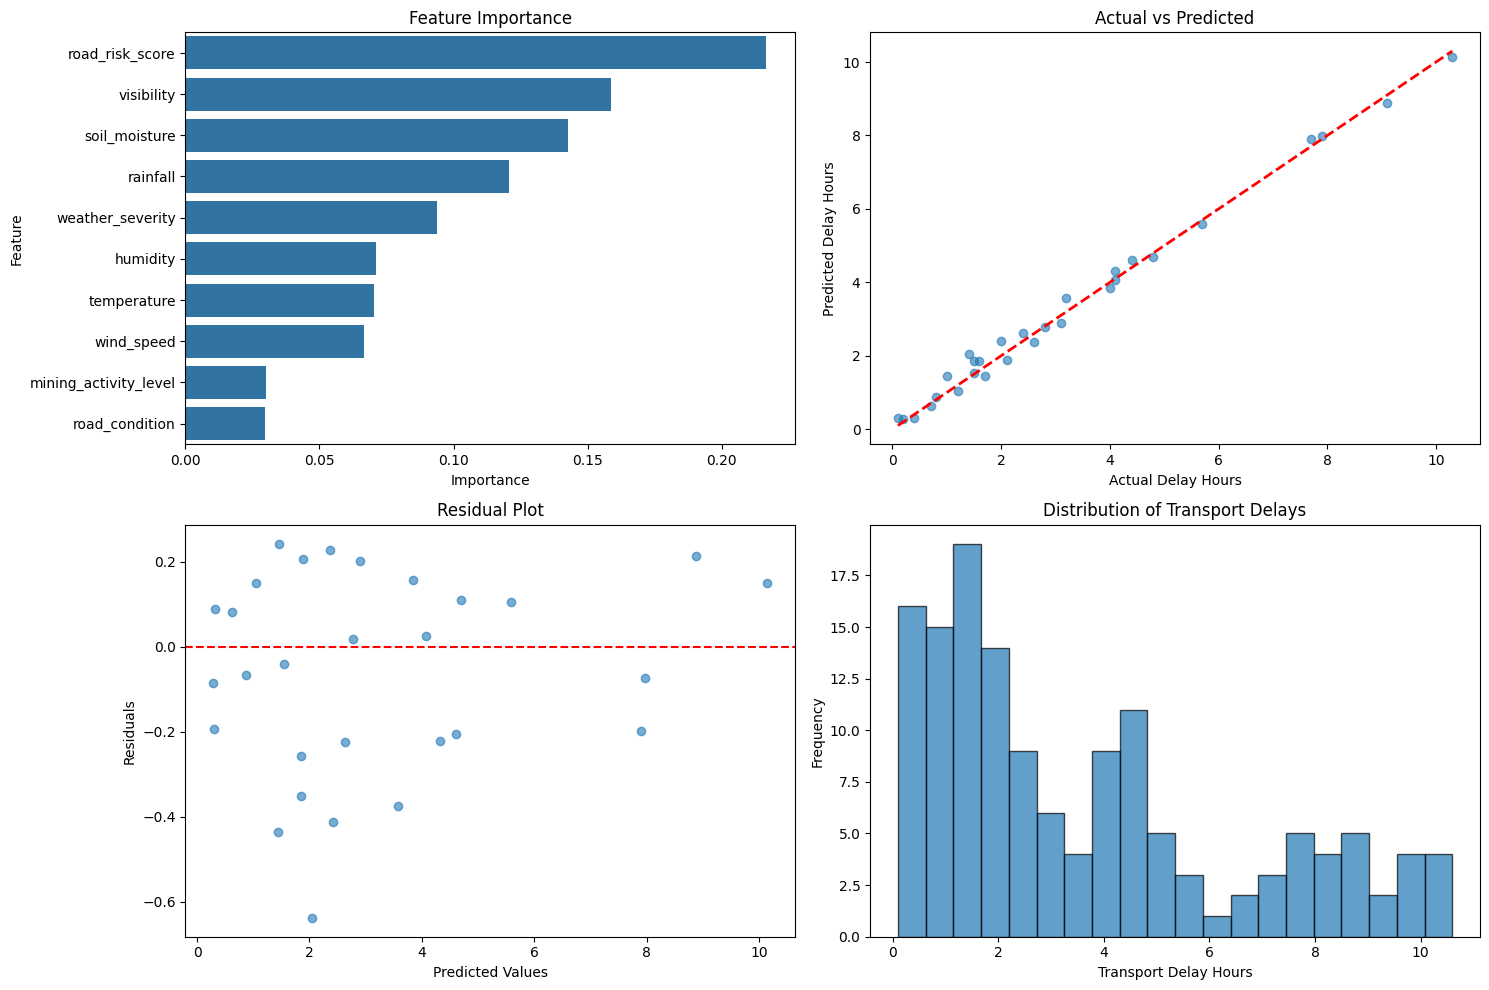


Model saved successfully to '../models/random_forest_model.pkl'

SAMPLE PREDICTIONS
Sample 1: Predicted Delay = 0.31 hours
Sample 2: Predicted Delay = 3.57 hours
Sample 3: Predicted Delay = 2.78 hours
Sample 4: Predicted Delay = 2.63 hours
Sample 5: Predicted Delay = 0.62 hours


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('../data/synthetic_weather_data.csv')
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nDescriptive statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Feature Engineering
# Create target variable: 1 if delay > 4 hours, else 0
df['high_delay_risk'] = (df['transport_delay_hours'] > 4).astype(int)

# Create weather severity index
df['weather_severity'] = (
    df['rainfall'] * 0.3 + 
    df['wind_speed'] * 0.2 + 
    (100 - df['visibility']) * 0.25 + 
    df['humidity'] * 0.15 +
    (30 - df['temperature']).abs() * 0.1
)

# Create road risk score
df['road_risk_score'] = (
    (10 - df['road_condition']) * 0.4 +
    df['soil_moisture'] * 0.3 +
    df['rainfall'] * 0.3
)

# Features and target
features = [
    'temperature', 'humidity', 'wind_speed', 'rainfall',
    'visibility', 'road_condition', 'soil_moisture',
    'mining_activity_level', 'weather_severity', 'road_risk_score'
]

X = df[features]
y = df['transport_delay_hours']  # Regression target
y_class = df['high_delay_risk']   # Classification target

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest Regressor
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

rf_regressor.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_regressor.predict(X_test_scaled)

# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_regressor.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*50)
print("FEATURE IMPORTANCE")
print("="*50)
print(feature_importance)

# Visualizations
plt.figure(figsize=(15, 10))

# 1. Feature Importance
plt.subplot(2, 2, 1)
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

# 2. Actual vs Predicted
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Delay Hours')
plt.ylabel('Predicted Delay Hours')
plt.title('Actual vs Predicted')

# 3. Residual Plot
plt.subplot(2, 2, 3)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# 4. Delay Distribution
plt.subplot(2, 2, 4)
plt.hist(df['transport_delay_hours'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Transport Delay Hours')
plt.ylabel('Frequency')
plt.title('Distribution of Transport Delays')

plt.tight_layout()
plt.show()

# Save model and scaler
model_data = {
    'model': rf_regressor,
    'scaler': scaler,
    'features': features,
    'metrics': {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2
    }
}

joblib.dump(model_data, '../models/random_forest_model.pkl')
print("\nModel saved successfully to '../models/random_forest_model.pkl'")

# Create sample predictions for demonstration
sample_data = X_test_scaled[:5]
predictions = rf_regressor.predict(sample_data)

print("\n" + "="*50)
print("SAMPLE PREDICTIONS")
print("="*50)
for i, pred in enumerate(predictions):
    print(f"Sample {i+1}: Predicted Delay = {pred:.2f} hours")